In [17]:
from lib import itselfmiti1,util

import numpy as np
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I,Y
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA
from qiskit.circuit.library import TwoLocal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq.job import job_monitor
#from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.providers.aer import AerSimulator  , QasmSimulator
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import Operator
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library.standard_gates import SGate,SdgGate,ry,rz
import qiskit.quantum_info as qi
from qiskit.exceptions import QiskitError
from qiskit.quantum_info.states.quantum_state import QuantumState
from qiskit import IBMQ
from qiskit.extensions import CXGate, CZGate, U1Gate, U3Gate
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector



from qiskit.circuit.random import random_circuit
from qiskit.utils.mitigation.fitters import CompleteMeasFitter,TensoredFilter,TensoredMeasFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal



import numpy as np
import matplotlib.pyplot as plt
from math import pi as pi

from qiskit.visualization import array_to_latex as lm


import random
import copy



In [18]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibm_nairobi'))
backend_real_jakarta = provider.get_backend('ibm_nairobi')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta

ibmqfactory.load_account:WARNING:2022-11-22 16:17:16,753: Credentials are already in use. The existing account in the session will be replaced.


In [19]:
depth=4
N_qubits=7
shots=10000
qubits=[0,1,2,3,4,5,6]
qubits_measure=qubits
backend=backend_sim_noisy_jakarta

In [20]:
def Hamiltonian_heisenberg(g,h):
  X1 = X^X^X^X^I^I^I
  X2 = I^I^I^X^X^X^X
  Z1 = Z^I^I^I^I^I^I
  Z2 = I^Z^I^I^I^I^I
  Z3 = I^I^Z^I^I^I^I
  Z4 = I^I^I^Z^I^I^I
  Z5 = I^I^I^I^Z^I^I
  Z6 = I^I^I^I^I^Z^I
  Z7 = I^I^I^I^I^I^Z

  H=(h*X1) + \
    (h*X2) + \
    (g*Z1) + \
    (g*Z2) + \
    (g*Z3) + \
    (g*Z4) + \
    (g*Z5) + \
    (g*Z6) + \
    (g*Z7)
  return H

In [21]:
H=Hamiltonian_heisenberg(1,1)

In [22]:
def ham(num_qubits,depth):
  theta = ParameterVector("t",depth*2)
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  #for i in range (0,5):
  #  circuit.h(qr[i])
  for _ in range (0,depth): 
    for i in range (0,5):
      circuit.rz(theta[index],qr[i])
    index+=1

    
    circuit.cx(qr[2],qr[3])
    circuit.cx(qr[1],qr[2])
    circuit.cx(qr[0],qr[1])
    circuit.cx(qr[4],qr[3])
    circuit.cx(qr[5],qr[4])
    circuit.cx(qr[6],qr[5])

    circuit.rx(theta[index],qr[0])
    #index+=1
    circuit.rx(theta[index],qr[6])
    index+=1

    circuit.cx(qr[6],qr[5])
    circuit.cx(qr[5],qr[4])
    circuit.cx(qr[4],qr[3])
    circuit.cx(qr[0],qr[1])
    circuit.cx(qr[1],qr[2])
    circuit.cx(qr[2],qr[3])
  
    
  return circuit


In [23]:
TwoLocal_ansatz=TwoLocal(7,'ry','cx','linear',reps=4, insert_barriers=True)

In [24]:
Heisenberg_ansatz=ham(N_qubits,depth)
Heisenberg_ansatz.draw()

┌──────────┐               ┌──────────┐            ┌──────────┐»
q7100_0: ┤ Rz(t[0]) ├────────────■──┤ Rx(t[1]) ├─────■──────┤ Rz(t[2]) ├»
         ├──────────┤          ┌─┴─┐└──────────┘   ┌─┴─┐    └──────────┘»
q7100_1: ┤ Rz(t[0]) ├───────■──┤ X ├───────────────┤ X ├─────────■──────»
         ├──────────┤     ┌─┴─┐└───┘               └───┘       ┌─┴─┐    »
q7100_2: ┤ Rz(t[0]) ├──■──┤ X ├────────────────────────────────┤ X ├────»
         ├──────────┤┌─┴─┐├───┤                                └───┘    »
q7100_3: ┤ Rz(t[0]) ├┤ X ├┤ X ├─────────────────────────────────────────»
         ├──────────┤└───┘└─┬─┘┌───┐                                    »
q7100_4: ┤ Rz(t[0]) ├───────■──┤ X ├────────────────────────────────────»
         └──────────┘          └─┬─┘   ┌───┐                   ┌───┐    »
q7100_5: ────────────────────────■─────┤ X ├───────────────────┤ X ├────»
                                       └─┬─┘    ┌──────────┐   └─┬─┘    »
q7100_6: ────────────────────────────────■──────┤ Rx(t[1]) ├─────■──────»
                                                └──────────┘            »
«                                                                 ┌──────────┐»
«q7100_0: ─────────────────────────────────────────────────────■──┤ Rx(t[3]) ├»
«         ┌──────────┐                                       ┌─┴─┐└──────────┘»
«q7100_1: ┤ Rz(t[2]) ├────────────────────────────────────■──┤ X ├────────────»
«         └──────────┘                 ┌──────────┐     ┌─┴─┐└───┘            »
«q7100_2: ──────────────────────■──────┤ Rz(t[2]) ├──■──┤ X ├─────────────────»
«                     ┌───┐   ┌─┴─┐    ├──────────┤┌─┴─┐├───┤                 »
«q7100_3: ────────────┤ X ├───┤ X ├────┤ Rz(t[2]) ├┤ X ├┤ X ├─────────────────»
«            ┌───┐    └─┬─┘┌──┴───┴───┐└──────────┘└───┘└─┬─┘┌───┐            »
«q7100_4: ───┤ X ├──────■──┤ Rz(t[2]) ├───────────────────■──┤ X ├────────────»
«            └─┬─┘         └──────────┘                      └─┬─┘   ┌───┐    »
«q7100_5: ─────■───────────────────────────────────────────────■─────┤ X ├────»
«                                                                    └─┬─┘    »
«q7100_6: ─────────────────────────────────────────────────────────────■──────»
«                                                                             »
«                     ┌──────────┐                                         »
«q7100_0: ─────■──────┤ Rz(t[4]) ├─────────────────────────────────────────»
«            ┌─┴─┐    └──────────┘┌──────────┐                             »
«q7100_1: ───┤ X ├─────────■──────┤ Rz(t[4]) ├─────────────────────────────»
«            └───┘       ┌─┴─┐    └──────────┘                 ┌──────────┐»
«q7100_2: ───────────────┤ X ├──────────────────────────■──────┤ Rz(t[4]) ├»
«                        └───┘                ┌───┐   ┌─┴─┐    ├──────────┤»
«q7100_3: ────────────────────────────────────┤ X ├───┤ X ├────┤ Rz(t[4]) ├»
«                                    ┌───┐    └─┬─┘┌──┴───┴───┐└──────────┘»
«q7100_4: ───────────────────────────┤ X ├──────■──┤ Rz(t[4]) ├────────────»
«                        ┌───┐       └─┬─┘         └──────────┘            »
«q7100_5: ───────────────┤ X ├─────────■───────────────────────────────────»
«         ┌──────────┐   └─┬─┘                                             »
«q7100_6: ┤ Rx(t[3]) ├─────■───────────────────────────────────────────────»
«         └──────────┘                                                     »
«                        ┌──────────┐            ┌──────────┐                 »
«q7100_0: ────────────■──┤ Rx(t[5]) ├─────■──────┤ Rz(t[6]) ├─────────────────»
«                   ┌─┴─┐└──────────┘   ┌─┴─┐    └──────────┘┌──────────┐     »
«q7100_1: ───────■──┤ X ├───────────────┤ X ├─────────■──────┤ Rz(t[6]) ├─────»
«              ┌─┴─┐└───┘               └───┘       ┌─┴─┐    └──────────┘     »
«q7100_2: ──■──┤ X ├────────────────────────────────┤ X ├─────────────────────»
«         ┌─┴─┐├───┤                                └───┘       

In [25]:
def ansatz_cal(qc,qubits,backend=BACKEND):
    num_param=qc.num_parameters
    randomlist = []
    config=backend.configuration()
    N_qubits_backend=config.n_qubits
    for i in range(0,num_param):
        n = random.randint(0,100)
        n=2*n*np.pi/100
        randomlist.append(n)
    print(randomlist)
    qr_cal=QuantumRegister(N_qubits)
    qc_cal=QuantumCircuit(qr_cal)
    
    qc_cal.append(qc,qr_cal)
    qc_cal_bound=qc_cal.assign_parameters(randomlist)
    #qc_cal=transpile(qc_cal,BACKEND,optimization_level=0)
    return qc_cal_bound

In [26]:
def Calibration(circ_cal,backend=BACKEND,qubits=qubits,shots_cal=shots):
  
  config=backend.configuration()
  N_qubits_backend=config.n_qubits
  N_qubits=len(qubits)


  meas_calibs, state_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits)
  job_cal = execute(meas_calibs, backend=BACKEND, shots=shots)
  cal_results = job_cal.result()
  cal_counts=cal_results.get_counts()
  meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')


  qr = QuantumRegister(N_qubits_backend,name="q")
  qr_qubits=[]
  for qubit in qubits:
    qr_qubits.append(qr[qubit])
  #cr=ClassicalRegister(N_qubits)
  qc = QuantumCircuit(qr)
  qc.append(circ_cal,qr_qubits)
  qc=transpile(qc,backend,optimization_level=0)
  print(qc.count_ops())
  
  cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc,qubits_measure=qubits)

  job_GEM_L = execute(cal_circs_GEM[0], backend, shots=shots_cal/2, optimization_level=0)
  job_GEM_R = execute(cal_circs_GEM[1], backend, shots=shots_cal/2, optimization_level=0)
  result_L=job_GEM_L.result()
  result_R=job_GEM_R.result()
  print(result_L.get_counts()[0])
  print(result_R.get_counts()[0])
  meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L.result(), state_labels=state_labels)
  meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R.result(), state_labels=state_labels)
  C_L = meas_fitter_GEM_L.cal_matrix
  C_R = meas_fitter_GEM_R.cal_matrix
  C_GEM = (C_L+C_R)/2
  print(C_L-C_R)

  rand_vec_prob=np.sum(C_GEM,axis=1,dtype='float')/(len(s_labels))
  C_plus=np.zeros((len(s_labels),len(s_labels)))
  p_t=(C_GEM[0][0]-1)/(rand_vec_prob[0]-1)
  print('p_t')
  print(p_t)

    #define the random prob vector and equilibrium prob vector
  print('rand_vec')
  print(rand_vec_prob)
  rand_vec=p_t*shots*rand_vec_prob
  for k in range (0,len(s_labels)):
    for j in range (0,len(s_labels)):
      C_plus[k][j]=(C_GEM[k][j]-p_t*rand_vec_prob[k])/(1-p_t)

  plt.figure(figsize=(10,16))
  plt.subplot(411)
  plt.imshow(C_GEM)
  plt.colorbar()
  plt.subplot(412)
  plt.imshow(C_plus)
  plt.colorbar()
  print(C_GEM)

  meas_fitter_GP=copy.deepcopy(meas_fitter_GEM_L)
  meas_fitter_GP.cal_matrix=C_plus

  meas_fitter_GEM=copy.deepcopy(meas_fitter_GEM_R)
  meas_fitter_GEM.cal_matrix=C_GEM
  
  return meas_fitter_GEM,meas_fitter_GP,meas_fitter

[3.141592653589793, 4.71238898038469, 5.15221195188726, 2.4504422698000385, 4.838052686528282, 0.06283185307179587, 5.717698629533423, 1.2566370614359172]
OrderedDict([('cx', 114), ('rz', 44), ('sx', 16)])
{'1000110': 5, '1011110': 3, '0110111': 29, '1111100': 24, '0000000': 1533, '0000111': 40, '1110100': 68, '0010000': 37, '0101001': 9, '1111011': 36, '0000001': 202, '1111000': 338, '0001100': 102, '1110000': 78, '0000011': 82, '0110100': 11, '1110011': 40, '0011100': 6, '0111100': 6, '1110111': 91, '0001101': 107, '0111000': 84, '1111010': 39, '0000010': 110, '0100111': 16, '1010000': 21, '0000101': 25, '1111111': 28, '0100000': 71, '1110001': 21, '0001011': 47, '1110110': 87, '0001110': 129, '1110010': 14, '0010100': 10, '1011000': 60, '0100011': 13, '1010110': 6, '1101111': 19, '1111001': 66, '1001011': 5, '0100100': 7, '0001111': 204, '1110101': 44, '0010101': 10, '0001000': 87, '0010111': 25, '0011000': 49, '1010100': 9, '0110011': 12, '1101000': 30, '0000100': 107, '1001000': 1

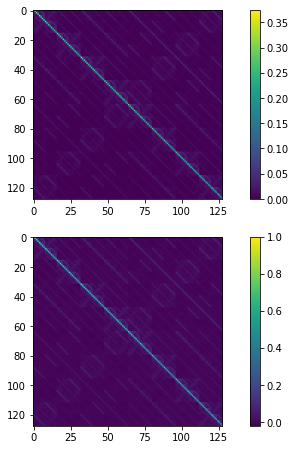

In [27]:
heisenberg_cal=ansatz_cal(Heisenberg_ansatz,qubits=qubits)
meas_GEM_hami,meas_GP_hami,meas_fitter=Calibration(heisenberg_cal,BACKEND,qubits=qubits)

[3.330088212805181, 0.25132741228718347, 3.707079331235956, 3.204424506661589, 5.0893800988154645, 0.9424777960769378, 5.466371217246239, 4.0212385965949355, 3.015928947446201, 2.261946710584651, 5.15221195188726, 2.9530970943744057, 5.529203070318036, 5.340707511102648, 5.026548245743669, 1.9477874452256716, 2.199114857512855, 2.261946710584651, 3.4557519189487724, 4.209734155810323, 5.717698629533423, 1.7592918860102842, 0.06283185307179587, 4.523893421169302, 5.15221195188726, 3.9584067435231396, 4.900884539600077, 0.18849555921538758, 6.283185307179586, 3.7699111843077513, 4.335397861953915, 5.529203070318036, 0.9424777960769378, 5.026548245743669, 5.466371217246239]
OrderedDict([('rz', 105), ('cx', 96), ('sx', 70), ('barrier', 8)])
{'1110101': 3, '0001111': 67, '0111010': 12, '1111110': 5, '0110001': 11, '0000110': 134, '0110111': 17, '0000000': 1372, '1110000': 40, '0001100': 154, '0010110': 38, '0111100': 33, '0001101': 35, '1110001': 2, '0111110': 7, '0000001': 70, '0111111': 1

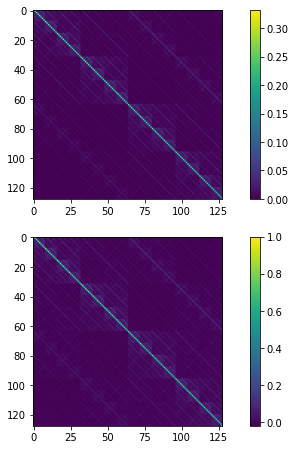

In [28]:
Two_Local_cal=ansatz_cal(TwoLocal_ansatz,qubits=qubits)
meas_GEM_two,meas_GP_two,meas_fitter=Calibration(Two_Local_cal,BACKEND,qubits=qubits)

In [29]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -7.24740


VQE on Aer qasm simulator (no noise): -5.46094
Delta from reference energy value is: 1.78646


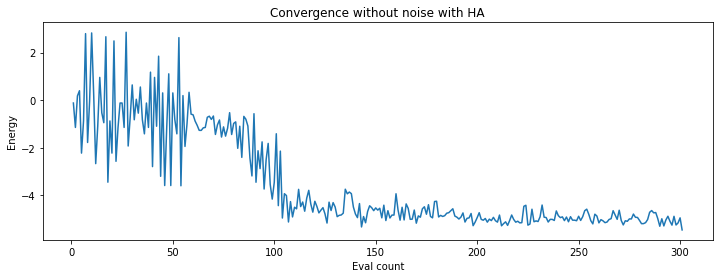

In [30]:
seed = 100
iterations = 125
shots=8192
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,optimization_level=0)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(Heisenberg_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result.eigenvalue.real-ref_value):.5f}")

# Plot energy values
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts,values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence without noise with HA')
pylab.show()

VQE on Aer qasm simulator (no noise): -6.00391
Delta from reference energy value is: 1.24349


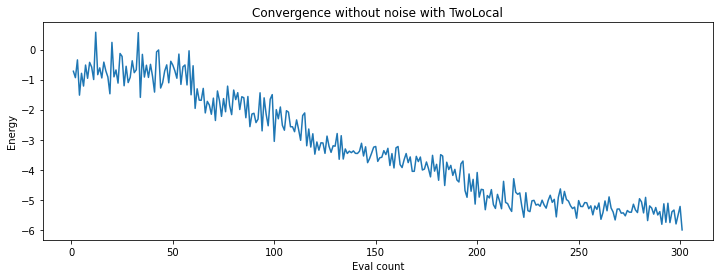

In [31]:
seed = 100
iterations = 125
shots=8192
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,optimization_level=0)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(TwoLocal_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result.eigenvalue.real-ref_value):.5f}")

# Plot energy values
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts,values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence without noise with TwoLocal')
pylab.show()

In [32]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_h_meas = QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,optimization_level=0,initial_layout=qubits,measurement_error_mitigation_cls=CompleteMeasFitter)

def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(Heisenberg_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi_h_meas)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")

# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and measurement error mitigation with HA')
    pylab.show()


VQE on Aer qasm simulator (with noise and measurement error mitigation): -4.04883
Delta from reference energy value is: 0.42331


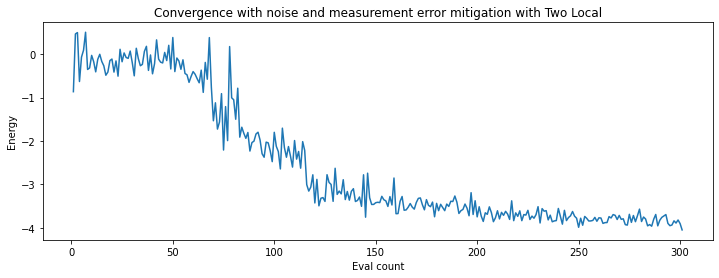

In [ ]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_t_meas= QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,
                      measurement_error_mitigation_cls=CompleteMeasFitter,optimization_level=0,initial_layout=qubits)
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(TwoLocal_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi_t_meas)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")

# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and measurement error mitigation with Two Local')
    pylab.show()


VQE on Aer qasm simulator (with noise and measurement error mitigation): -4.37109
Delta from reference energy value is: 0.10104


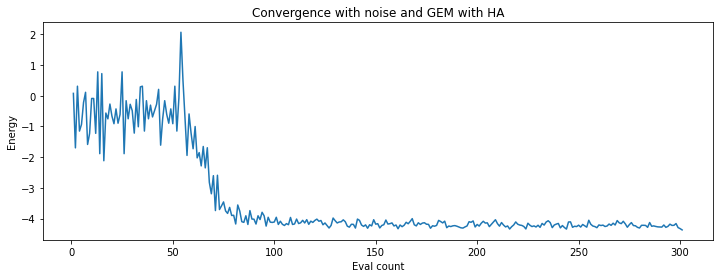

In [ ]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_h_GEM= QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,optimization_level=0,initial_layout=qubits,measurement_error_mitigation_cls=CompleteMeasFitter)
qi_h_GEM.measurement_error_mitigation_cls.cal_matrix=meas_GEM_hami.cal_matrix
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(Heisenberg_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi_h_GEM)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")

# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and GEM with HA')
    pylab.show()


VQE on Aer qasm simulator (with noise and measurement error mitigation): -4.41406
Delta from reference energy value is: 0.05807
<bound method QuantumInstance.cals_matrix of <qiskit.utils.quantum_instance.QuantumInstance object at 0x2ADE3C10>>


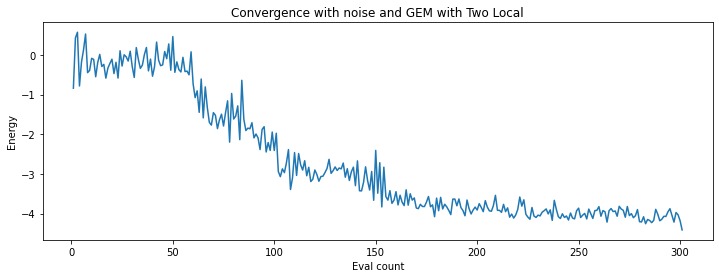

In [ ]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_t_GEM = QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,
                      measurement_error_mitigation_cls=CompleteMeasFitter,optimization_level=0,initial_layout=qubits)
qi_t_GEM.measurement_error_mitigation_cls.cal_matrix=meas_GEM_two.cal_matrix
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(TwoLocal_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")
print(qi.cals_matrix)
# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and GEM with Two Local')
    pylab.show()


In [ ]:
print(qi_h_meas.cals_matrix())

{'0_1_2_3_4_1024': (array([[0.7568, 0.0591, 0.0591, ..., 0.0021, 0.003 , 0.0019],
       [0.0259, 0.7133, 0.0087, ..., 0.0073, 0.0022, 0.0026],
       [0.036 , 0.0124, 0.7339, ..., 0.0012, 0.0064, 0.0022],
       ...,
       [0.0009, 0.0055, 0.001 , ..., 0.6692, 0.0081, 0.0504],
       [0.0022, 0.0016, 0.0051, ..., 0.0083, 0.6818, 0.054 ],
       [0.0014, 0.0028, 0.001 , ..., 0.0337, 0.0252, 0.6555]]), 1669126235.7289903)}


In [ ]:
print(qi_h_GEM.cals_matrix())

{'0_1_2_3_4_1024': (array([[0.7568, 0.0591, 0.0591, ..., 0.0021, 0.003 , 0.0019],
       [0.0259, 0.7133, 0.0087, ..., 0.0073, 0.0022, 0.0026],
       [0.036 , 0.0124, 0.7339, ..., 0.0012, 0.0064, 0.0022],
       ...,
       [0.0009, 0.0055, 0.001 , ..., 0.6692, 0.0081, 0.0504],
       [0.0022, 0.0016, 0.0051, ..., 0.0083, 0.6818, 0.054 ],
       [0.0014, 0.0028, 0.001 , ..., 0.0337, 0.0252, 0.6555]]), 1669126391.0034897)}
